Computer Vision Course Work

In [39]:
#import package
from google.colab import drive
#mount my drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
!pip install opencv-python==4.4.0.46

In [41]:
#import packages
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import joblib
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import data, exposure

In [42]:
#import package
import os
#setup paths
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_Folder' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE2 = 'Colab Notebooks/Computer Vision/CW_Folder/CW_Dataset' 
GOOGLE_DRIVE_PATH2 = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE2)
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH2, 'CW_Dataset.zip')
# Copy it to Colab
!cp '{zip_path}' .
# Unzip it
!yes|unzip -q CW_Dataset.zip
# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

replace test/test_0288_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0828_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1505_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0317_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1055_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0647_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2986_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1923_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0591_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2326_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1383_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2676_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_3064_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2819_aligned.jpg? [y

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16*22*22, 28)
        self.batchnorm1 = nn.BatchNorm1d(28)
        self.fc2 = nn.Linear(28, 14)
        self.batchnorm2 = nn.BatchNorm1d(14)
        self.dropout = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(14, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*22*22)
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net = Net()

In [44]:
#variables
test = 'test'

SVM = 'SVM'
MLP = 'MLP'
CNN = 'CNN'
error = 'error'


def EmotionRecognition(test_set, model_type):
  #setup train folder path
  test_data = test_set
  #create empty list
  images = []
  #extract files
  file_names = [file for file in sorted(os.listdir(os.path.join(test_data))) if file.endswith('.jpg')]
  #append files to empty list
  for file in file_names:
    images.append(io.imread(os.path.join(test_data, file)))

  #setup label folder path
  test_labels = 'labels/list_label_test.txt'
  #bring in file
  labels = np.genfromtxt(test_labels)
  #convert to list
  labels = labels.tolist()
  #extract second element in each list
  labels = [item[1] for item in labels]
    
  if model_type=="CNN":
        _image = np.array(images)
        image = torch.from_numpy(_image)
        image = image.permute(0,3, 1, 2)
        images2=image.numpy()
        labels=np.asarray(labels)
        images3 = images2.astype('float32')
        images3 /= 255.0

        if torch.cuda.is_available():  
            dev = "cuda:0" 
        else:  
            dev = "cpu"  
            device = torch.device(dev) 
            dev = "cpu"

        X_test = torch.FloatTensor(images3).to(dev)
        y_test = torch.FloatTensor(labels).to(dev)
        test = torch.utils.data.TensorDataset(X_test,y_test)
        testloader = torch.utils.data.DataLoader(test, batch_size = 10, shuffle = False)

        model_save_name = 'CNN.pt'
        path = F"/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder/Models/{model_save_name}"
        CNN = torch.load(path)
        CNN = CNN.eval()
        correct = 0
        total = 0

        with torch.no_grad():             # Avoid backprop at test 
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                outputs = net(inputs)
                _,predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels-1).sum().item()
        print(f"validate images: {100 * correct / total}%")
        test1 = X_test.numpy()
        test1 = torch.from_numpy(test1)
        test2 = test1.permute(0,2, 3, 1)
        test3 = test2.numpy()
        #test3, y_test, predicted = shuffle(images, labels, predicted)
        fig, axes = plt.subplots(1, 4, 
        figsize=(14, 7), sharex=True, sharey=True)
        ax = axes.ravel()

        for i in range(4):
            ax[i].imshow(test3[i])
            ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {predicted[i]+1}')
            ax[i].set_axis_off()
        fig.tight_layout()
        plt.show()

        print(f"test images: {100 * correct / total}%")

  elif  model_type=="MLP":
  
            # Create empty lists for feature descriptors and labels
            des_list = []
            y_valid_list = []

            for i in range(len(images)):
             # Extract descriptors with Hog
                HOG_des, HOG_image = hog(images[i], visualize=True, multichannel=True)
                HOG_image_rescaled = exposure.rescale_intensity(HOG_image)

                # Append list of descriptors and label to respective lists
                if HOG_des is not None:
                    des_list.append(HOG_des)
                    y_valid_list.append(labels[i])

            # Convert to array for easier handling
            des_array = np.vstack(des_list)


            filename = '/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder/Models/MLP.sav'
            MLP = joblib.load(filename)
            predicted = MLP.predict(des_array)
            images, y_valid_list, predicted = shuffle(images, labels, predicted)
            fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
            ax = axes.ravel()

            for i in range(4):
                ax[i].imshow(images[i])
                ax[i].set_title(f'Label: {y_valid_list[i]} \n Prediction: {predicted[i]}')
                ax[i].set_axis_off()
            fig.tight_layout()
            plt.show()
            print(f"""Classification report for classifier {MLP}:
            {metrics.classification_report(y_valid_list, predicted)}\n""")

  elif model_type=="SVM":
 
            filename = '/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder/Models/SVM.sav'
            SVM = joblib.load(filename)
            filename = '/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder/Models/kmeans.sav'
            kmeans = joblib.load(filename)
            # Initiate SIFT detector
            sift = cv2.SIFT_create()
            # Number of centroids/codewords: good rule of thumb is 10*num_classes
            k = len(np.unique(labels)) * 10 
            hist_list = []
            for i in range(len(images)):
                img = img_as_ubyte(color.rgb2gray(images[i]))
                kp, des = sift.detectAndCompute(img, None)

                if des is not None:
                    hist = np.zeros(k)

                    idx = kmeans.predict(des)

                    for j in idx:
                        hist[j] = hist[j] + (1 / len(des))

                    # hist = scale.transform(hist.reshape(1, -1))
                    hist_list.append(hist)

                else:
                    hist_list.append(None)

            # Remove potential cases of images with no descriptors
            idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
            hist_list = [hist_list[i] for i in idx_not_empty]
            labels = [labels[i] for i in idx_not_empty]
            images = [images[i] for i in idx_not_empty]
            hist_array = np.vstack(hist_list)
            predicted = SVM.predict(hist_array).tolist()
            images, labels, predicted = shuffle(images, labels, predicted)
            fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
            ax = axes.ravel()
            for i in range(4):
                ax[i].imshow(images[i])
                ax[i].set_title(f'Label: {labels[i]} \n Prediction: {predicted[i]}')
                ax[i].set_axis_off()
            fig.tight_layout()
            plt.show()
            print(f"""Classification report for classifier {SVM}:
            {metrics.classification_report(labels, predicted)}\n""")
  else:
                    print("No Model Found")
  return

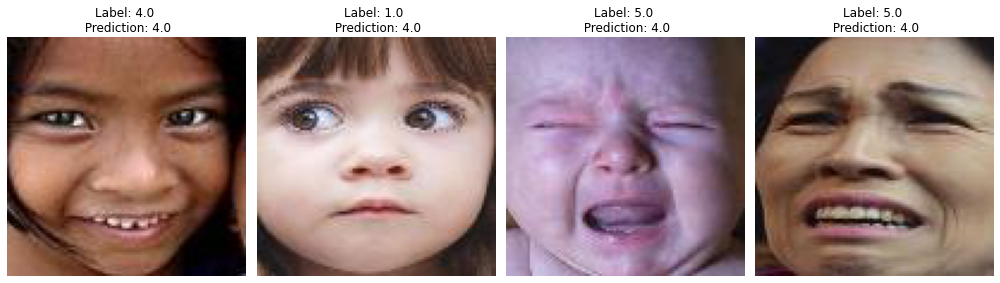

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=7, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
                          precision    recall  f1-score   support

         1.0       0.75      0.02      0.04       329
         2.0       0.00      0.00      0.00        74
         3.0       0.00      0.00      0.00       160
         4.0       0.41      0.93      0.57      1184
         5.0       0.00      0.00      0.00       478
         6.0       0.00      0.00      0.00       162
         7.0       0.39      0.20      0.27       679

    accuracy                           0.41      3066
   macro avg       0.22      0.17      0.12      3066
weighted avg       0.32      0.41      0.28      3066




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
EmotionRecognition(test,SVM)